### Deep Convolutional Generative Adversarial Networks

В наутбуке представлена реализация генеративно-состязательной сети, состоящих из сверточных слоев. Задача состоит в том, чтобы сгенерировать правдоподобные человеческие лица.

Сначала импортируем необходимые для работы библиотки.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

Загрузим данные. Будем использовать датасет лиц знаменитостей -- CelebA.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/ene8x232wpeqz7k/img_align_celeba.zip
!mkdir dataset
!unzip /content/img_align_celeba.zip -d /content/dataset/

Изменим размер изображений до 64 на 64 и нормализуем их. После чего создадим датасет и даталоадер.

In [ ]:
img_size = 64
batch_size = 128

transformer = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root='/content/dataset/', transform=transformer)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Опишем функцию для вывода изображений.

In [ ]:
def imshow(tensor):
    img = tensor.clamp(0, 1).transpose(0, 1).transpose(1, 2).numpy()
    img = np.array(255 * img, dtype=int)
    
    f, ax = plt.subplots(1, 1)
    ax.axis('off')
    ax.imshow(img)
    plt.show()

Посмотрим на пример кода.

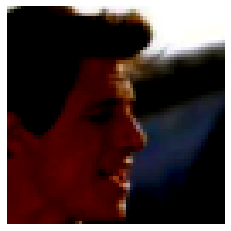

In [ ]:
imshow(dataset[2][0])

Вычисления будем производить на GPU, так как обучение GAN'ов долгое. 

Так же объявим некоторые константы -- количество каналов в изображении и размерность пространства, из которого будем сэмплировать шум.

In [ ]:
device = torch.device('cuda:0')
num_channels = 3
latent_size = 100

Опишем структуру генератора -- модели, целью которой является генерация лиц из шума.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size=100, base_size=512):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(latent_size, base_size, 4, 1, padding=0, bias=False),
            nn.BatchNorm2d(base_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_size, base_size // 2, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(base_size // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_size // 2, base_size // 4, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(base_size // 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_size // 4, base_size // 8, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(base_size // 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_size // 8, 3, 4, 2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x

Проверим корректность работы, то есть то, что генератор "производит" изображение правильной размерности.

In [ ]:
G = Generator().to(device)
z = torch.randn(batch_size, latent_size, 1, 1).to(device)
G(z).shape

torch.Size([128, 3, 64, 64])

Опишем структуру дискриминатора -- модели, которая будет учится отличать настоящие лица, от тех, что создал генератор.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, base_size=64):
        super().__init__()

        self.base_size = base_size

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, base_size, 4, 2, padding=1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(base_size, base_size * 2, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(base_size * 2),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(base_size * 2, base_size * 4, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(base_size * 4),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(base_size * 4, base_size * 8, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(base_size * 8),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(base_size * 8, 1, 4, 1, padding=0, bias=False),
            nn.Sigmoid(),
        )
     
    def forward(self, x):
        x = self.conv_layers(x)
        return x

Проверим работу дискриминатора.

In [ ]:
D = Discriminator().to(device)
z = torch.randn(1, latent_size, 1, 1).to(device)
D(G(z))

tensor([[[[0.5310]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

Инициализируем изначальыне веса моделей.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Опишем функцию для обучения дискриминатора. Оно будет проходить в несколько этапов:
1. Возьмем настоящие изображения и прогоним их через модель. Далее посчитаем binary cross entropy loss с вектором из единиц. 
2. С помощью генератора создадим "фейковые" изображения лиц и так же прогоним их через модель. Посчитам лосс с вектором из нулей.
3. Посчитаем сумму лоссов и сделаем backward().

In [ ]:
def D_train(data, D, G, current_size, labels0, labels1, noise):
    D.train()
    D.zero_grad()

    data = data.to(device)
    outp = D(data).view(current_size)

    D_loss1 = criterion(outp, labels1)

    results = G(noise).detach()
    outp = D(results).view(current_size)

    D_loss2 = criterion(outp, labels0)

    D_loss = D_loss1 + D_loss2
    D_loss.backward()
    optim_D.step()

    return D_loss.mean().item()

Опишем функцию для обучения генератора. Здесь мы генерируем изображения и прогоняем через дискриминатор, но лосс берем с векотором из 1 (хотя изображения фейковые), так как мы хотим, чтобы дискриминатор считал их настоящими.

In [ ]:
def G_train(D, G, current_size, labels0, labels1, noise):
    G.train()
    G.zero_grad()

    results = G(noise)
    outp = D(results).view(current_size)

    G_loss = criterion(outp, labels1)

    G_loss.backward()
    optim_G.step()

    return G_loss.mean().item()

Опишем вспомогательную функцию для логгирования лосса.

In [ ]:
def plot_history(D_losses, G_losses):
    print(f'  G loss: {G_losses[-1]}, D loss: {D_losses[-1]}')
    print()

    f, ax = plt.subplots(1, 1)
    ax.plot(D_losses)
    ax.plot(G_losses)
    ax.legend(['D loss', 'G loss'])
    plt.show()

Опишем вспомогательную функцию для логгирования результатов работы генератора.

In [ ]:
def plot_samples(images):
    for i in images: 
        imshow(i.detach().cpu())

Объявим генератор и дискриминатор, инициализируем их веса.

В качесве оптимизатора будем использовать AdamW для обоих моделей. Критерий -- Binary Cross Entropy.

Так же создадим вектор шума, чтобы каждые несколько итераций выводить результаты работы генератора на нем. Тем самым будем отслеживать эффективность обучения.

In [ ]:
num_epochs = 5
lr = 0.0002

G = Generator().to(device)
G.apply(weights_init)

D = Discriminator().to(device)
D.apply(weights_init)

G_losses = []
D_losses = []
iters = 0

optim_G = torch.optim.AdamW(G.parameters(), lr=lr, betas=(0.5, 0.999))
optim_D = torch.optim.AdamW(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(10, latent_size, 1, 1).to(device)

Запустим процесс обучения. Кажудю итерацию будем обучать дискриминатор и генератор, каждые 100 -- логировать лосс, кажые 500 -- выводить результаты генерации.

  G loss: 7.70075798034668, D loss: 0.3968711197376251



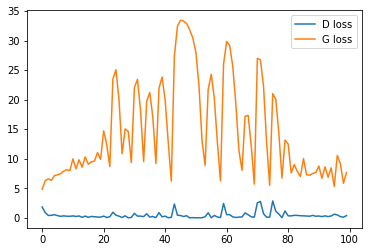

  G loss: 7.4091033935546875, D loss: 1.548958420753479



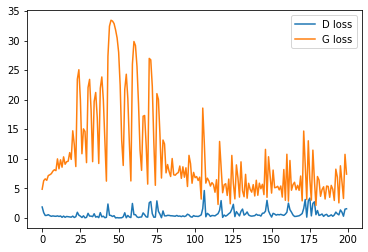

  G loss: 2.8309011459350586, D loss: 0.747587263584137



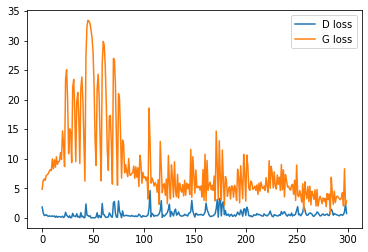

  G loss: 3.685286521911621, D loss: 0.48150527477264404



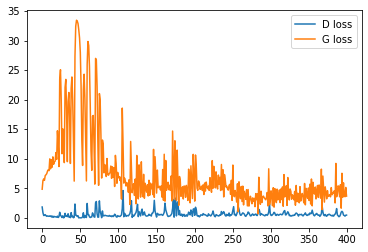

  G loss: 4.168394565582275, D loss: 0.686927855014801



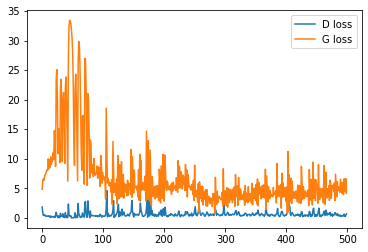

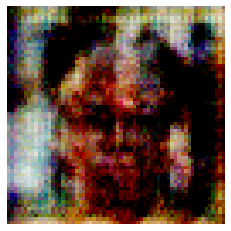

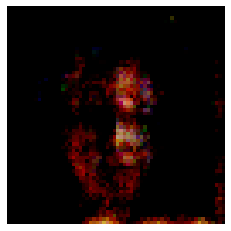

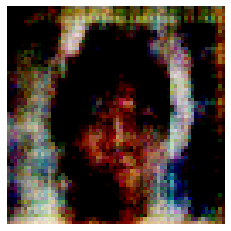

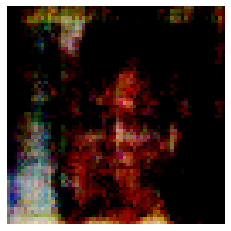

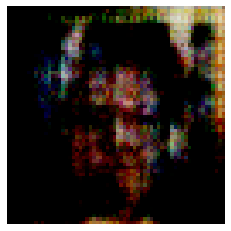

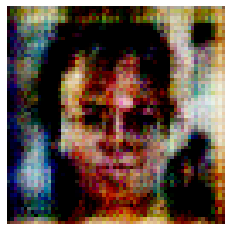

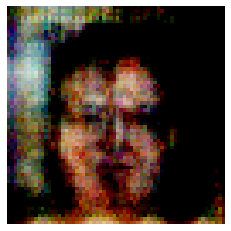

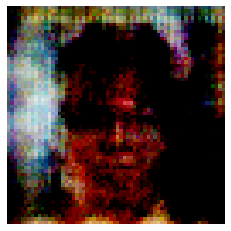

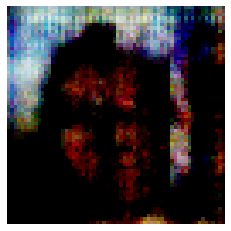

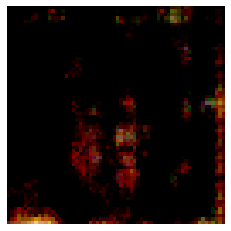

  G loss: 3.620138168334961, D loss: 0.4312801957130432



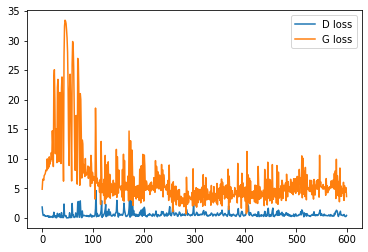

  G loss: 3.5039596557617188, D loss: 0.470746785402298



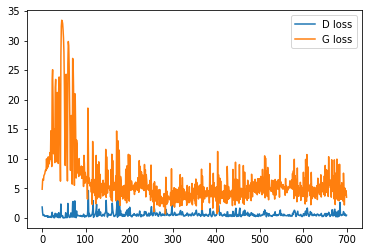

  G loss: 5.0638532638549805, D loss: 0.37523162364959717



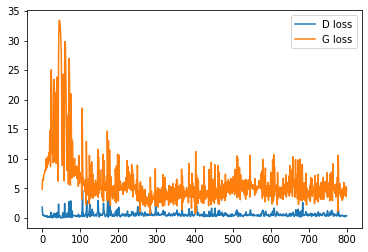

  G loss: 5.284630298614502, D loss: 0.4999493658542633



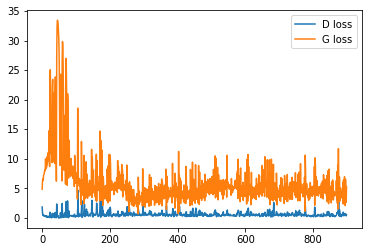

  G loss: 3.4051146507263184, D loss: 0.42013174295425415



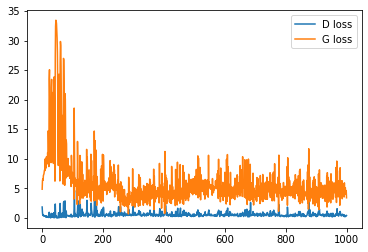

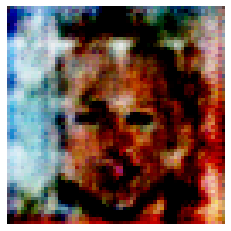

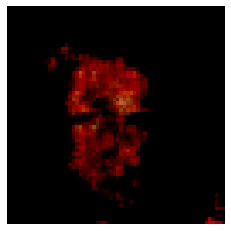

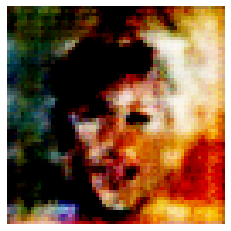

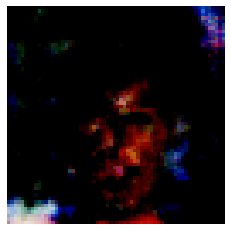

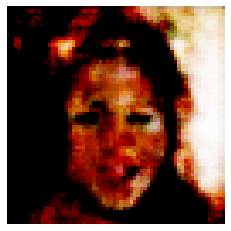

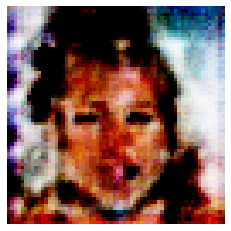

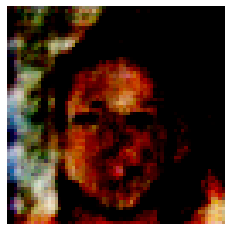

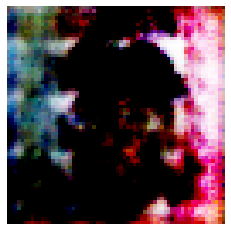

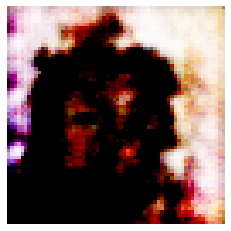

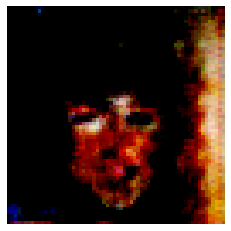

  G loss: 6.000070571899414, D loss: 0.7291948199272156



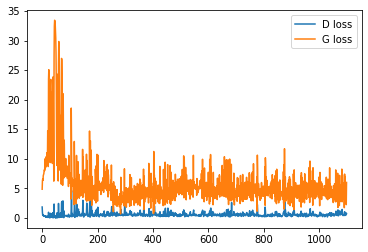

  G loss: 5.809823989868164, D loss: 0.6805123686790466



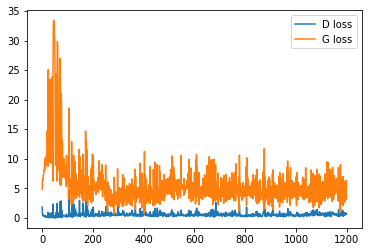

  G loss: 4.278234481811523, D loss: 0.5376689434051514



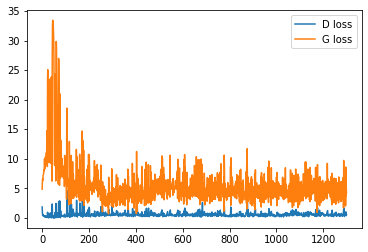

  G loss: 5.265926361083984, D loss: 0.4895859360694885



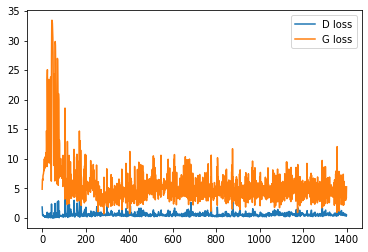

  G loss: 2.5656847953796387, D loss: 0.5442655086517334



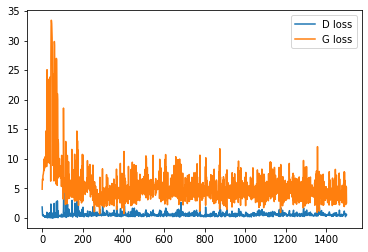

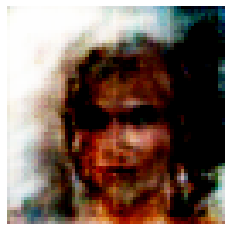

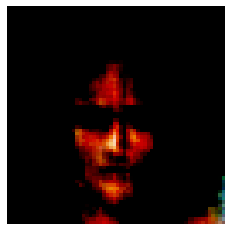

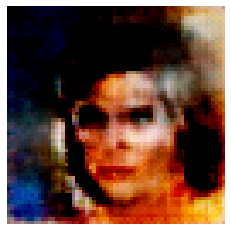

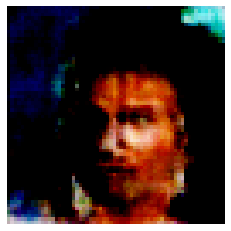

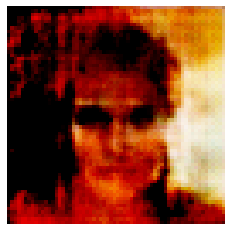

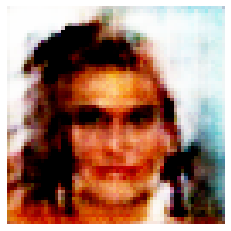

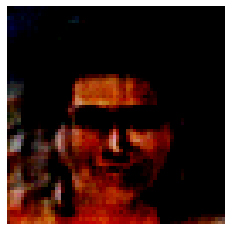

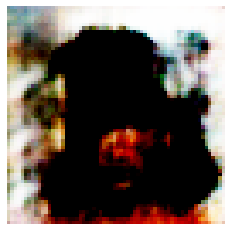

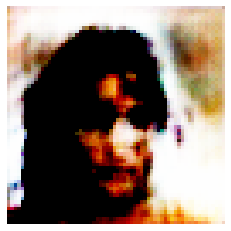

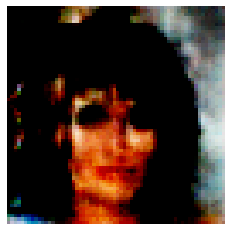

  G loss: 3.8298568725585938, D loss: 0.43160486221313477



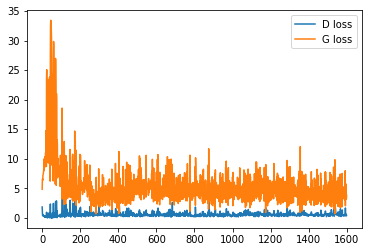

  G loss: 4.1847100257873535, D loss: 0.48317140340805054



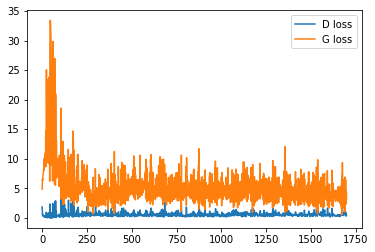

  G loss: 2.9876182079315186, D loss: 0.8953464031219482



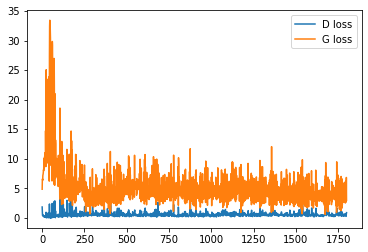

  G loss: 6.577390670776367, D loss: 0.8338584303855896



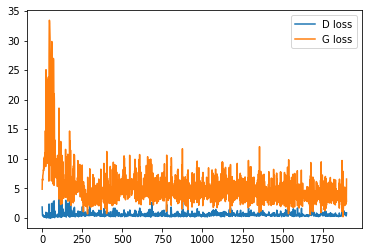

  G loss: 6.359184741973877, D loss: 1.5540094375610352



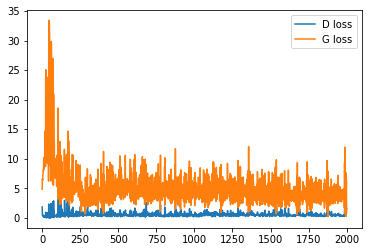

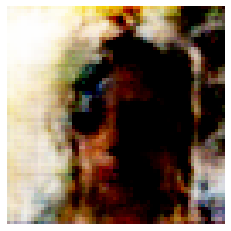

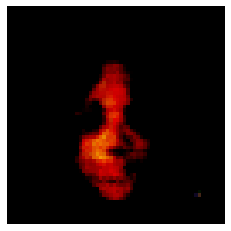

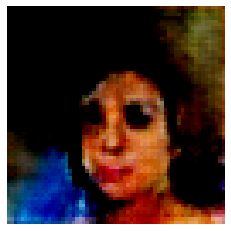

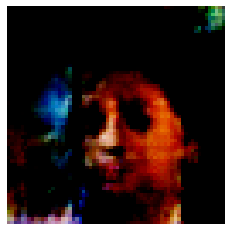

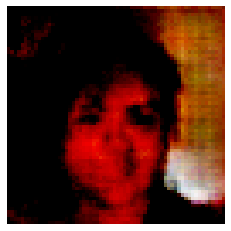

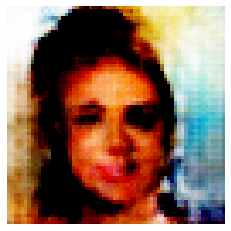

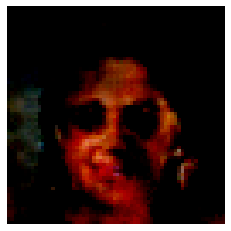

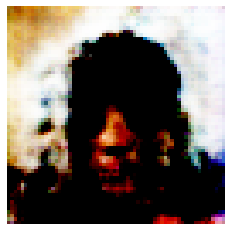

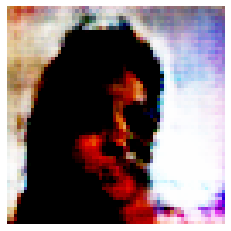

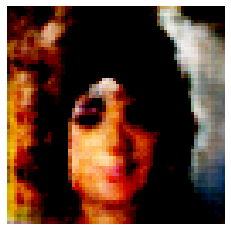

  G loss: 4.910488605499268, D loss: 0.4870191514492035



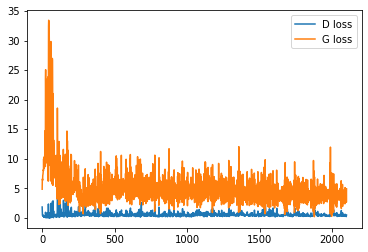

  G loss: 5.559000015258789, D loss: 0.4114187955856323



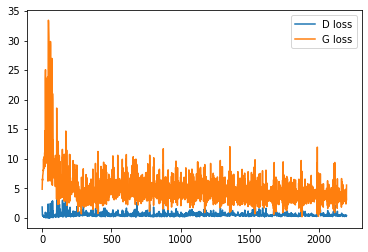

  G loss: 3.8662476539611816, D loss: 0.3664032220840454



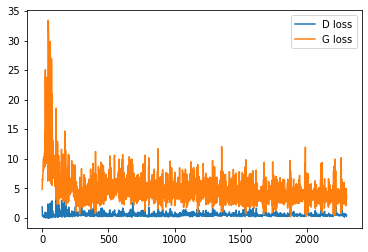

  G loss: 6.579590797424316, D loss: 0.5860713720321655



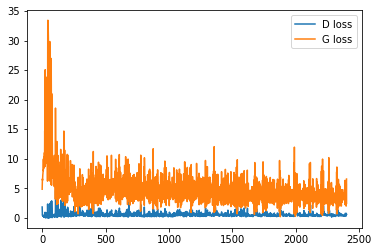

  G loss: 3.0856337547302246, D loss: 0.5251060724258423



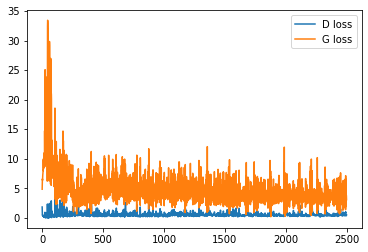

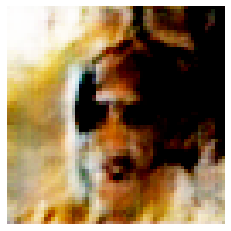

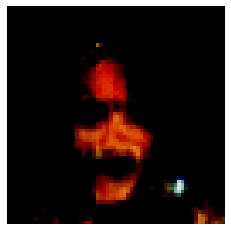

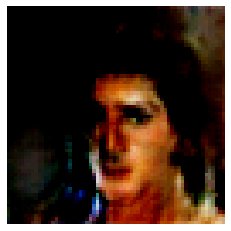

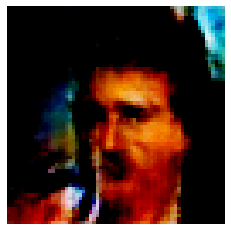

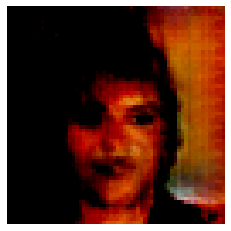

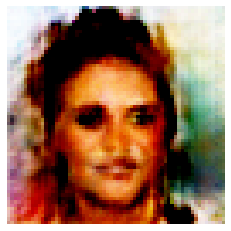

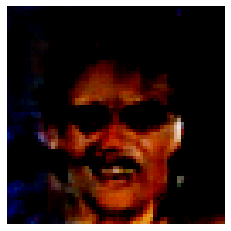

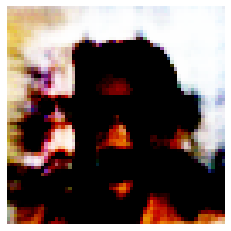

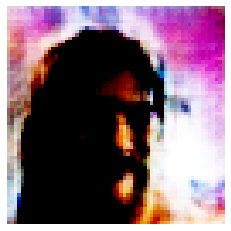

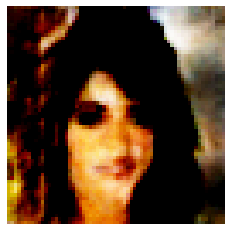

  G loss: 3.4241390228271484, D loss: 0.37392348051071167



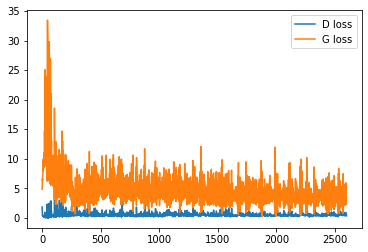

  G loss: 3.542595863342285, D loss: 0.38159751892089844



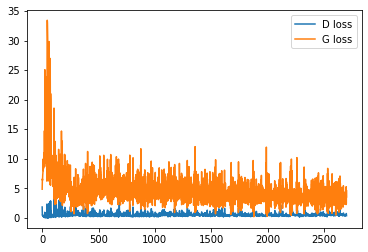

  G loss: 1.7636651992797852, D loss: 0.5570452213287354



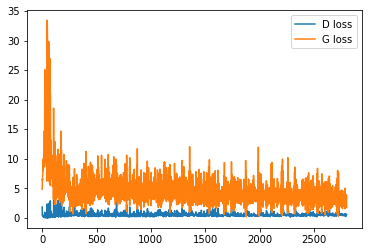

  G loss: 0.9771550297737122, D loss: 0.8655253052711487



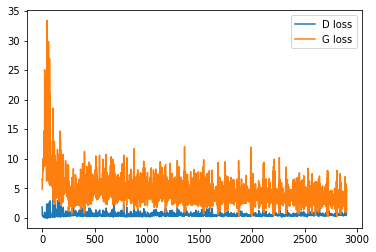

  G loss: 3.3140053749084473, D loss: 0.4082297086715698



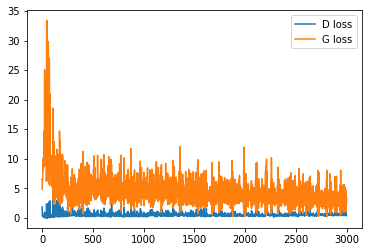

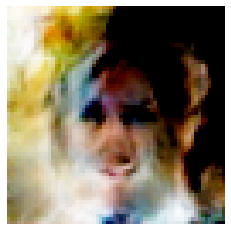

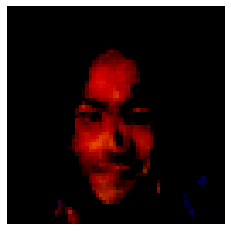

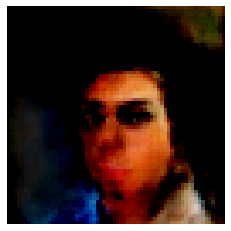

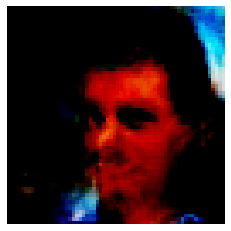

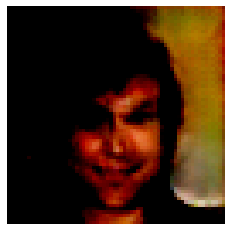

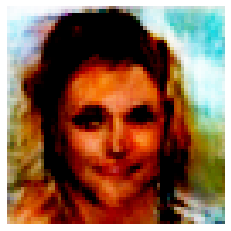

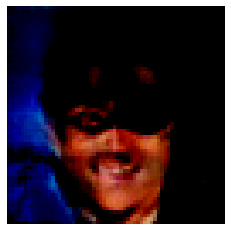

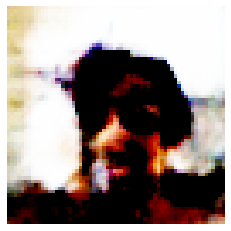

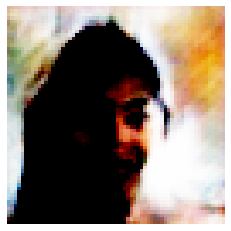

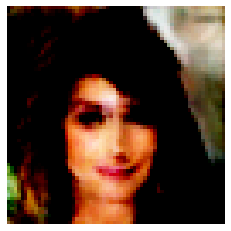

  G loss: 4.273311614990234, D loss: 0.8758258819580078



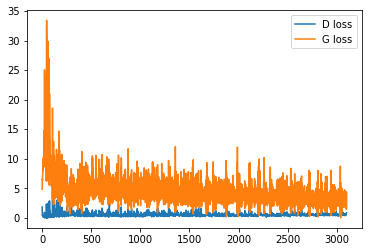

  G loss: 2.178161382675171, D loss: 0.5548675060272217



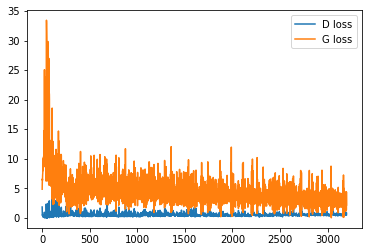

  G loss: 0.9503487944602966, D loss: 1.2708733081817627



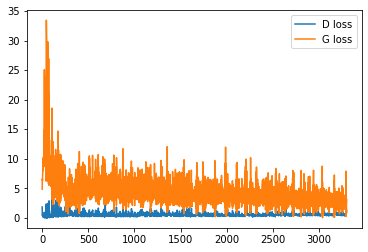

  G loss: 2.5557711124420166, D loss: 0.436612069606781



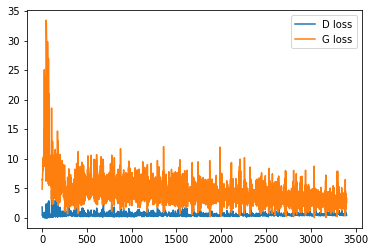

  G loss: 1.6776952743530273, D loss: 0.6411759853363037



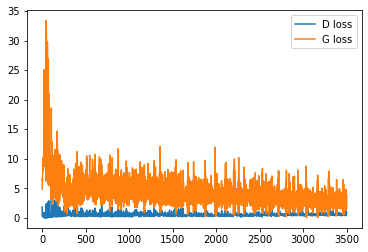

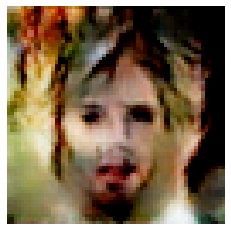

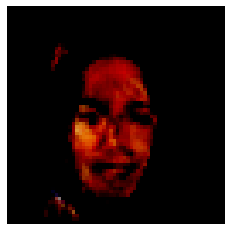

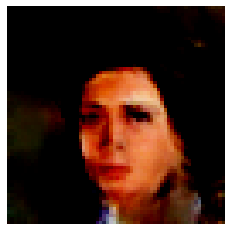

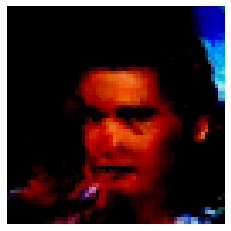

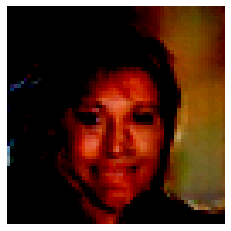

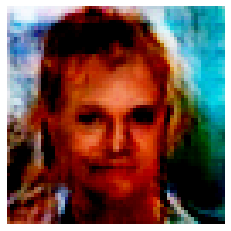

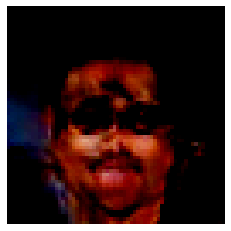

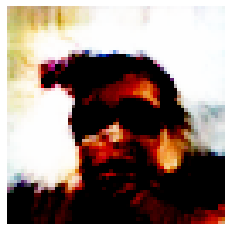

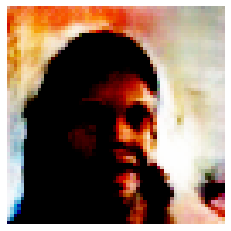

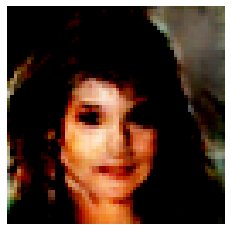

  G loss: 2.7211222648620605, D loss: 0.46454161405563354



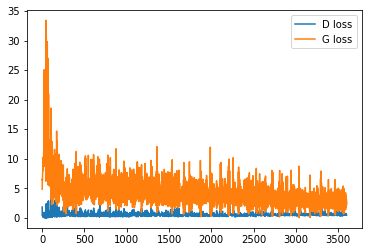

  G loss: 2.6713051795959473, D loss: 0.6171428561210632



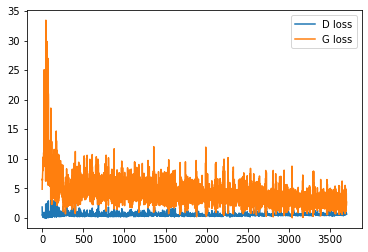

  G loss: 3.0659823417663574, D loss: 0.9463415145874023



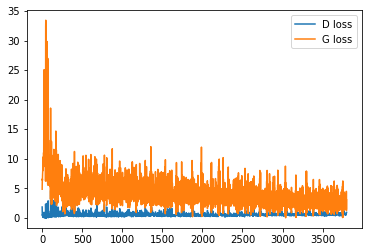

  G loss: 2.142099142074585, D loss: 0.6191614866256714



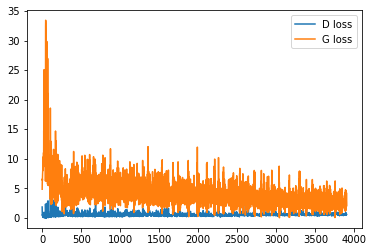

  G loss: 2.0947508811950684, D loss: 0.5848861932754517



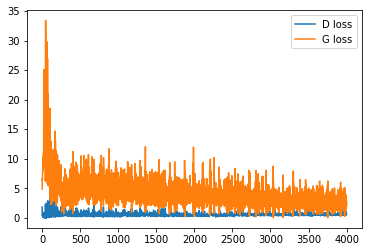

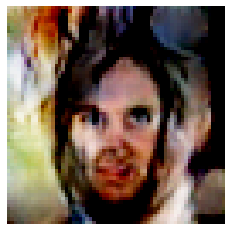

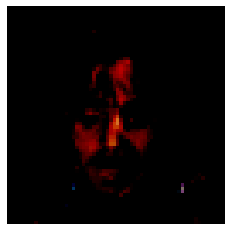

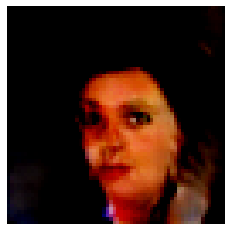

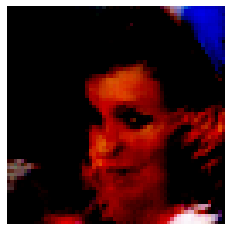

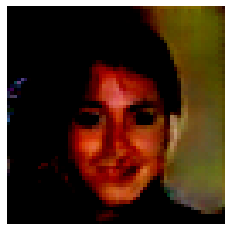

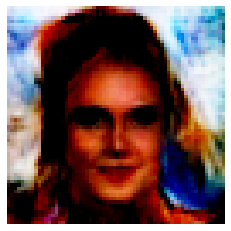

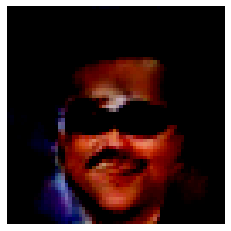

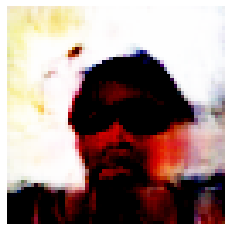

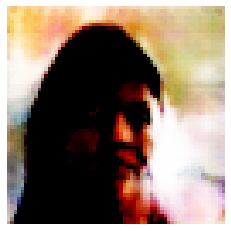

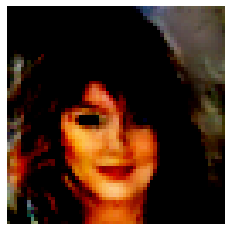

  G loss: 2.8188204765319824, D loss: 0.39684563875198364



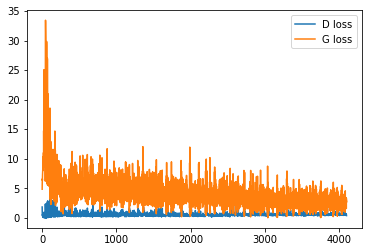

  G loss: 2.6694321632385254, D loss: 0.5115454196929932



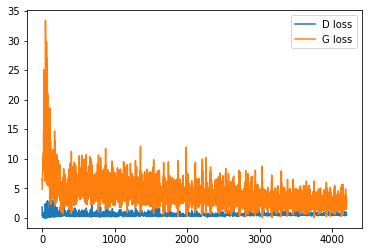

  G loss: 1.8817851543426514, D loss: 0.6056045293807983



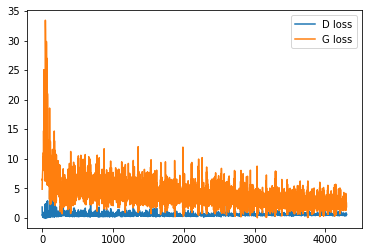

  G loss: 3.2673816680908203, D loss: 0.5988010168075562



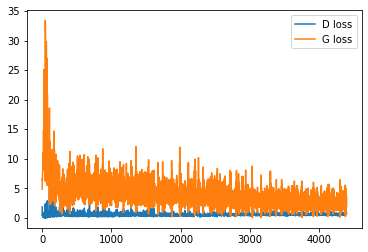

  G loss: 2.323235511779785, D loss: 0.6001363396644592



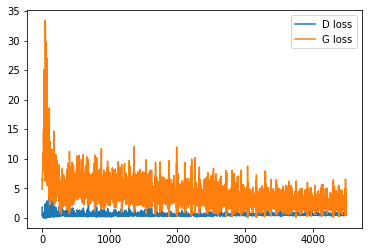

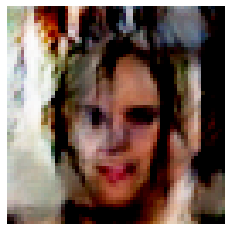

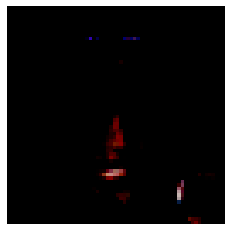

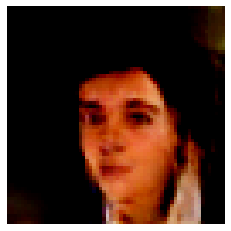

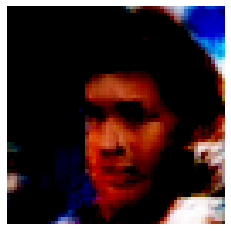

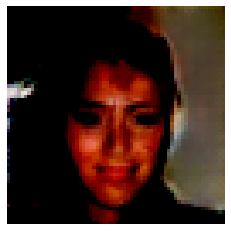

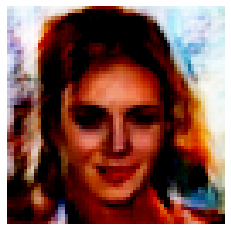

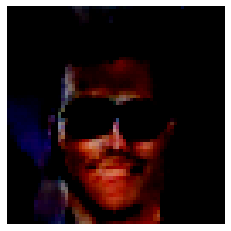

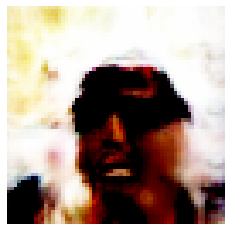

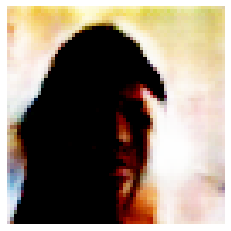

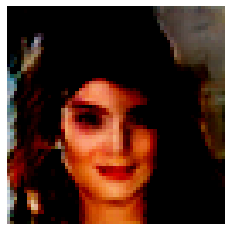

  G loss: 1.0173723697662354, D loss: 0.951865017414093



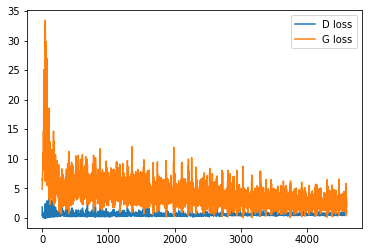

  G loss: 2.5750069618225098, D loss: 0.4701859951019287



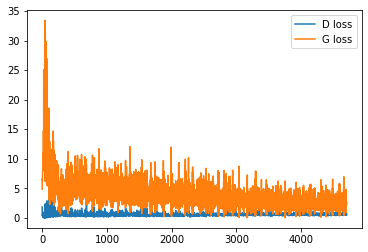

  G loss: 3.9004900455474854, D loss: 0.7904971837997437



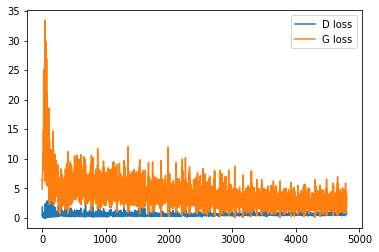

  G loss: 4.043686866760254, D loss: 0.8199307918548584



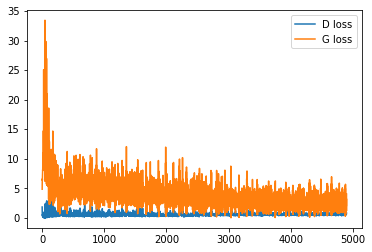

  G loss: 2.7519381046295166, D loss: 0.6711907386779785



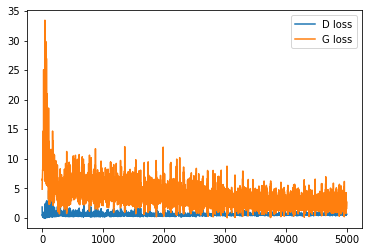

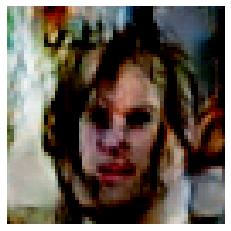

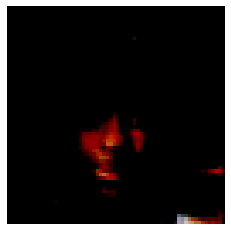

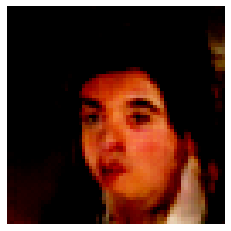

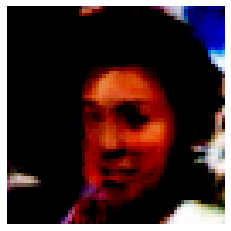

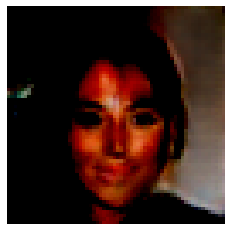

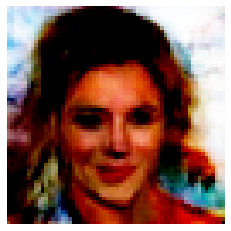

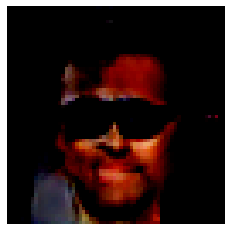

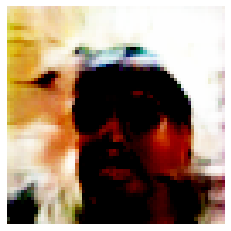

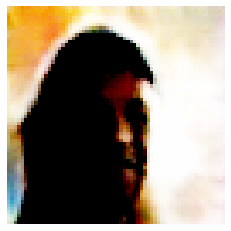

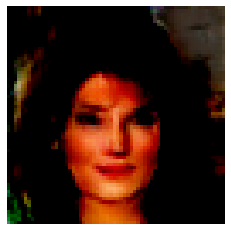

  G loss: 3.5553133487701416, D loss: 0.6241657137870789



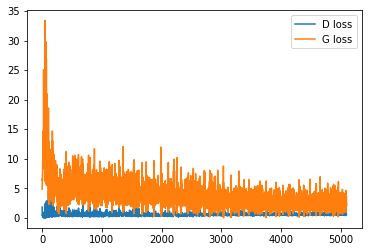

  G loss: 2.942941665649414, D loss: 0.40253809094429016



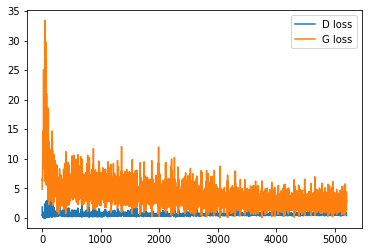

  G loss: 2.465646743774414, D loss: 0.4734152555465698



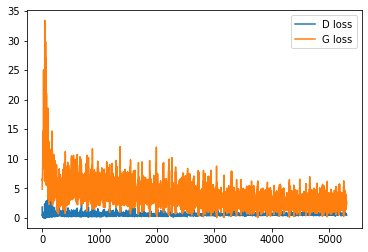

  G loss: 1.675433874130249, D loss: 0.6136967539787292



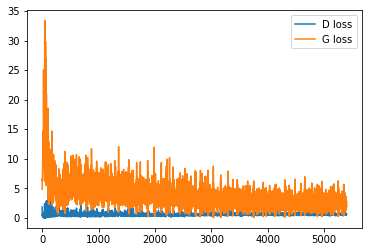

  G loss: 3.294174909591675, D loss: 0.644572377204895



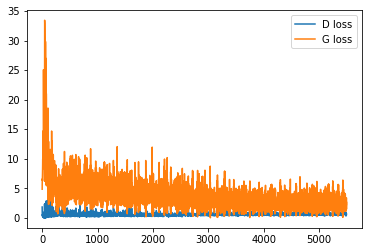

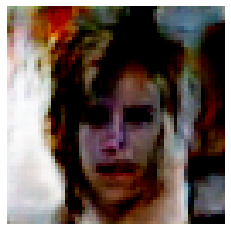

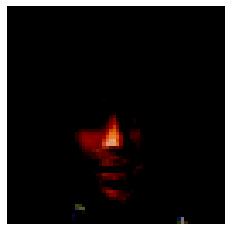

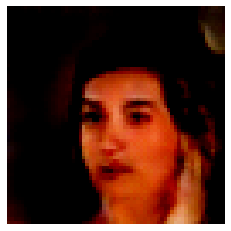

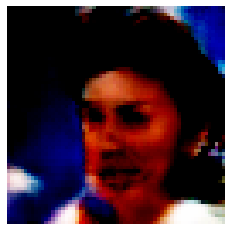

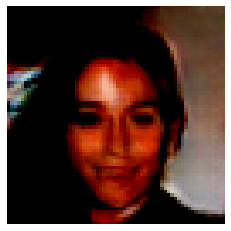

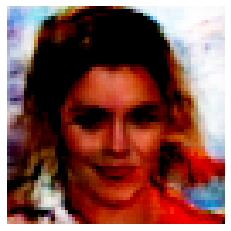

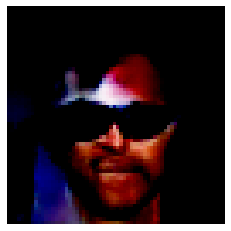

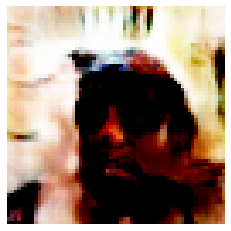

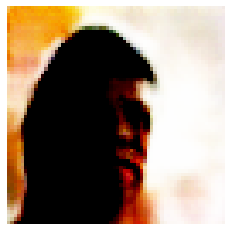

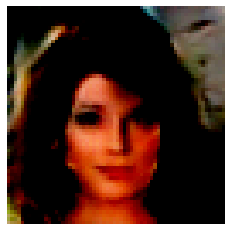

  G loss: 1.9422794580459595, D loss: 0.506462574005127



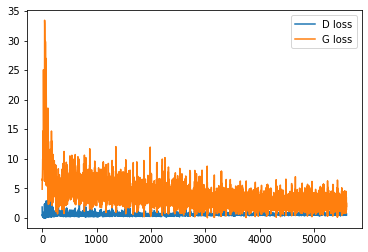

  G loss: 1.8961782455444336, D loss: 0.6377362608909607



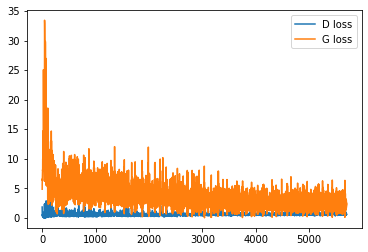

  G loss: 3.1334285736083984, D loss: 0.7193361520767212



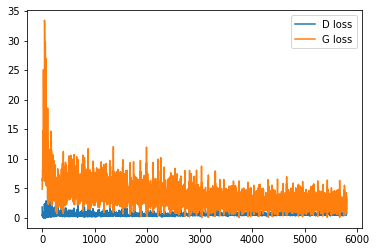

  G loss: 2.6118316650390625, D loss: 0.4960339665412903



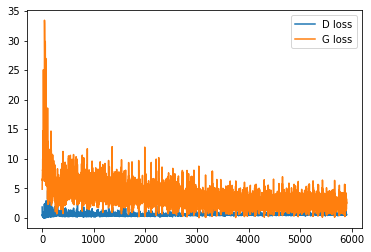

  G loss: 3.1799747943878174, D loss: 0.5055622458457947



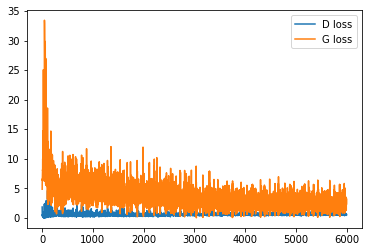

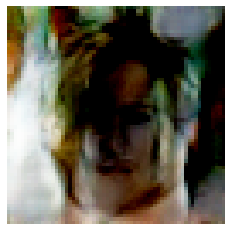

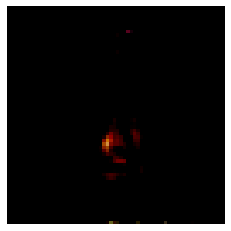

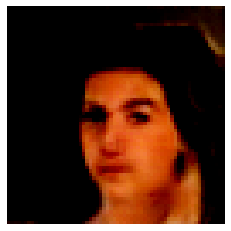

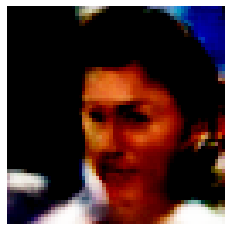

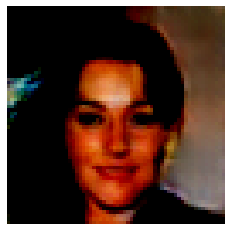

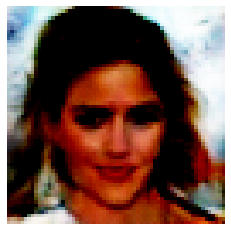

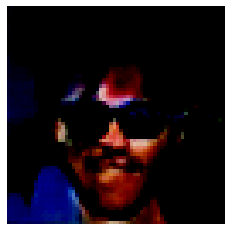

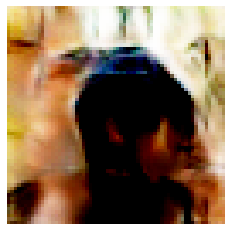

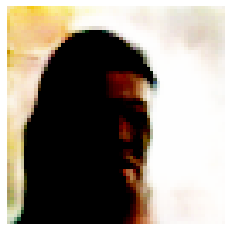

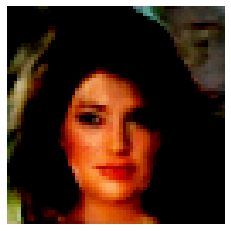

  G loss: 3.8524394035339355, D loss: 1.3147573471069336



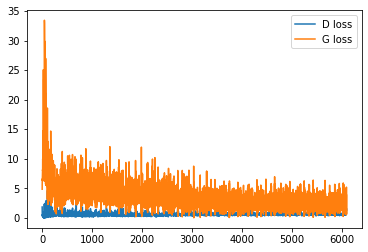

  G loss: 5.005678176879883, D loss: 1.2438361644744873



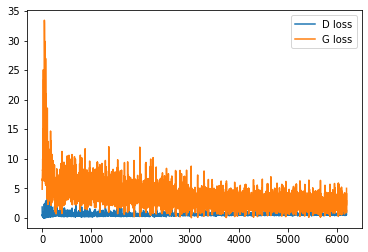

  G loss: 2.513108253479004, D loss: 0.4300614893436432



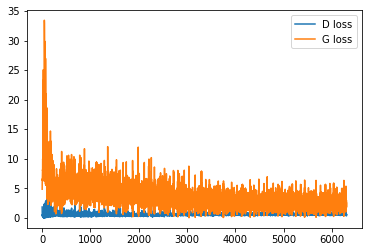

  G loss: 2.556689739227295, D loss: 0.4593256115913391



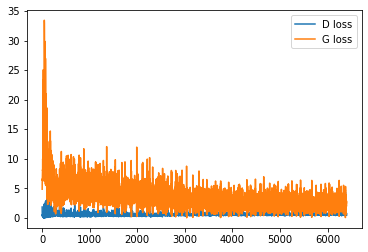

  G loss: 2.4539284706115723, D loss: 0.5917906761169434



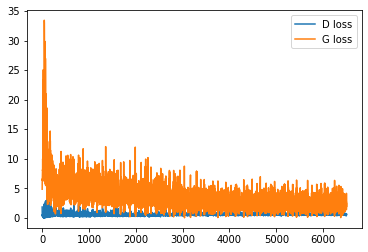

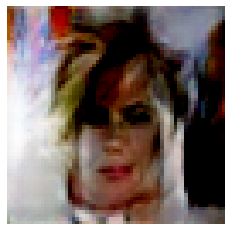

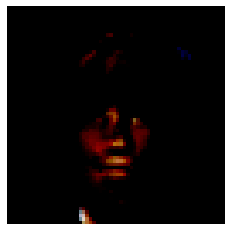

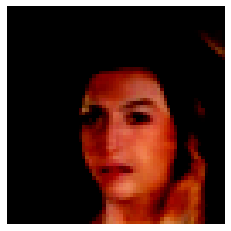

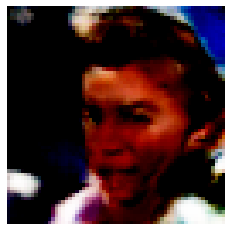

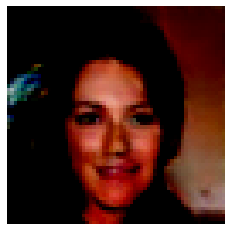

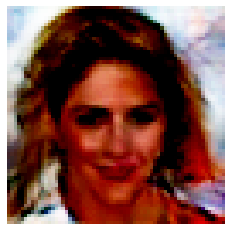

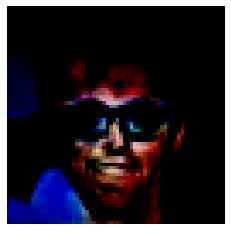

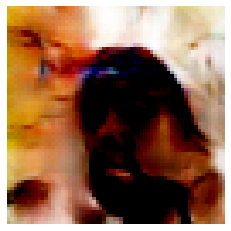

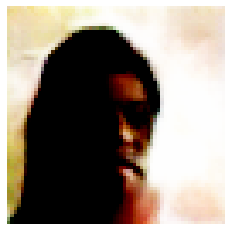

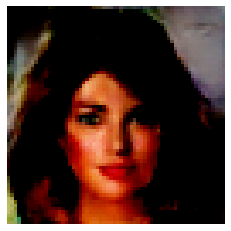

  G loss: 3.164604663848877, D loss: 0.5858516693115234



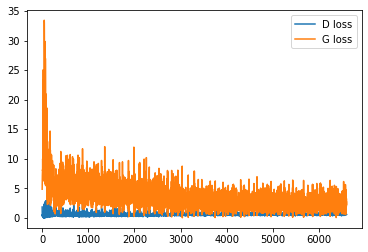

  G loss: 1.9616855382919312, D loss: 0.4884011149406433



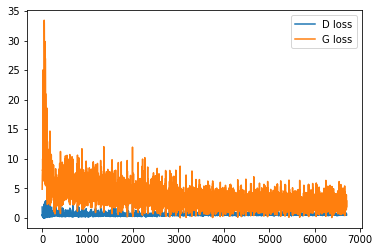

  G loss: 2.6397905349731445, D loss: 0.6835815906524658



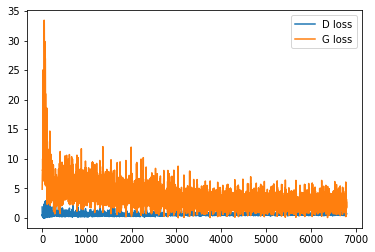

  G loss: 1.3627252578735352, D loss: 0.6469205021858215



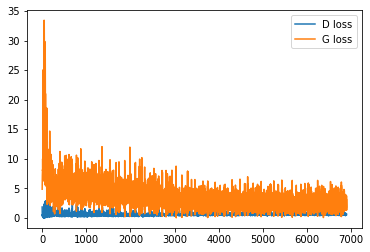

  G loss: 3.5398454666137695, D loss: 0.6200509071350098



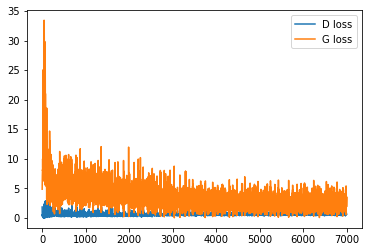

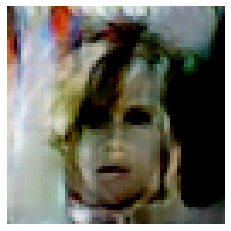

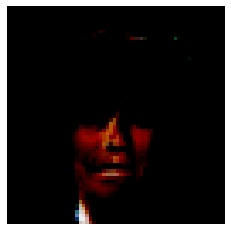

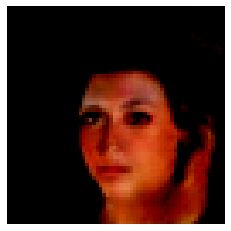

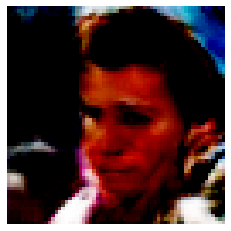

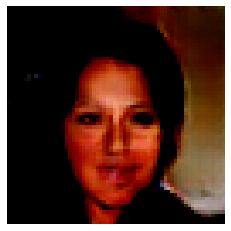

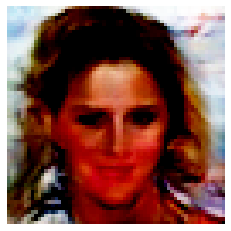

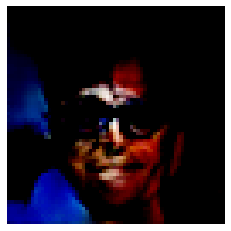

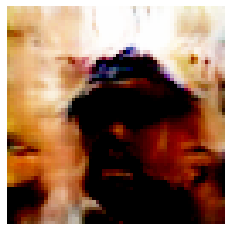

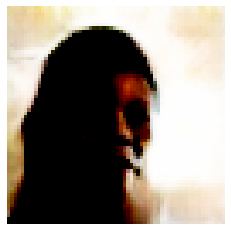

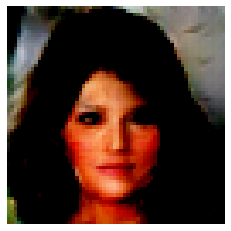

  G loss: 2.3988184928894043, D loss: 0.5232620239257812



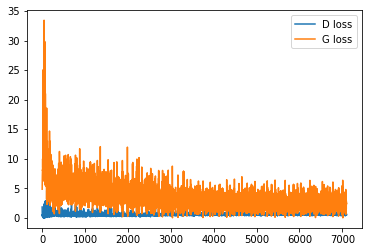

  G loss: 2.310527801513672, D loss: 0.4997314214706421



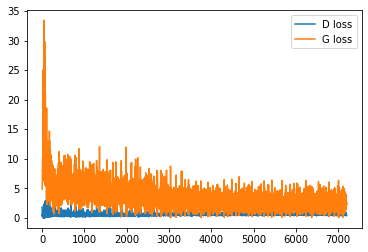

  G loss: 2.5143065452575684, D loss: 0.4828340709209442



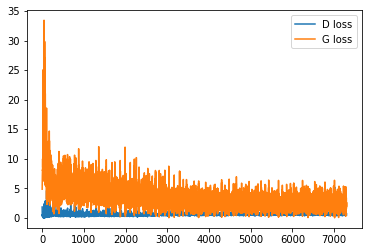

  G loss: 2.941678524017334, D loss: 0.5734822750091553



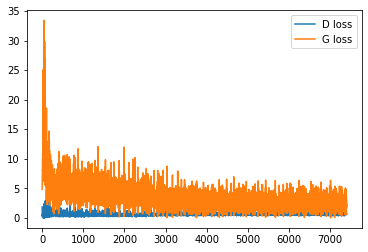

  G loss: 2.9117348194122314, D loss: 0.44602274894714355



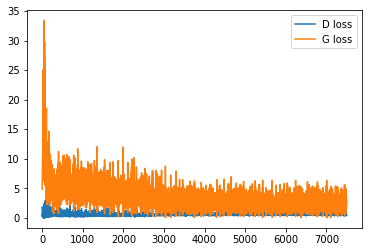

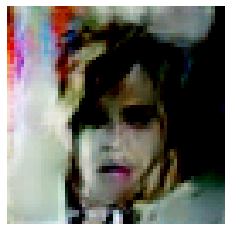

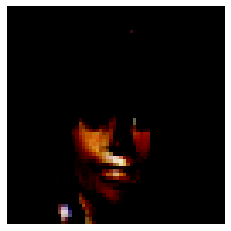

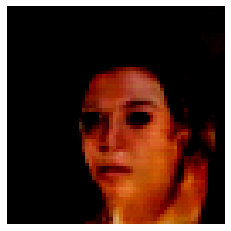

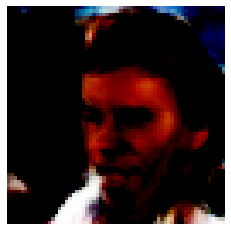

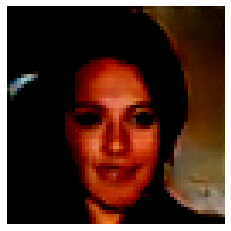

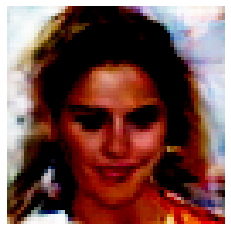

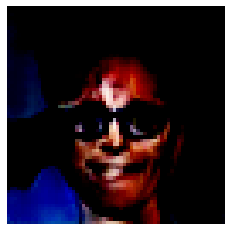

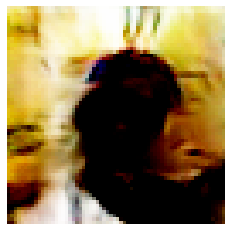

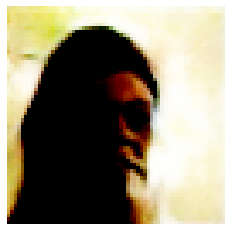

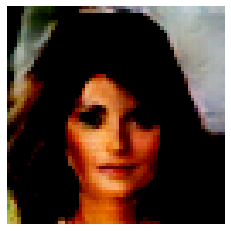

  G loss: 1.0887198448181152, D loss: 0.7398783564567566



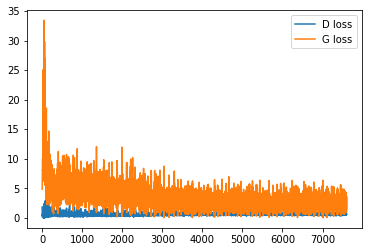

  G loss: 5.4865946769714355, D loss: 2.0084218978881836



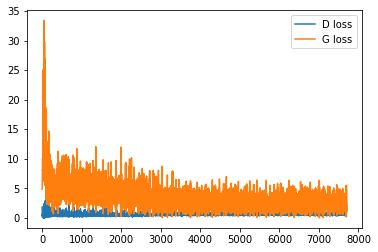

  G loss: 1.0085002183914185, D loss: 0.8814185857772827



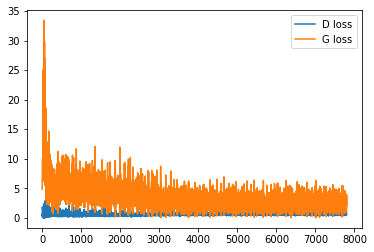

  G loss: 2.755581855773926, D loss: 0.46147802472114563



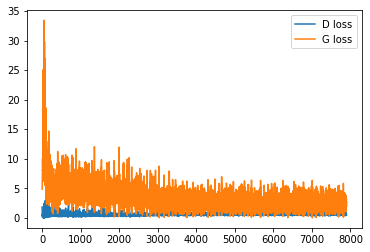

In [ ]:
for i in tqdm(range(num_epochs)):
    for data, _ in tqdm(loader):
        current_size = data.size(0)
 
        labels0 = torch.tensor([0] * current_size).to(device, torch.float)
        labels1 = torch.tensor([1] * current_size).to(device, torch.float)
        

        noise = torch.randn((current_size, latent_size, 1, 1)).to(device)

        D_loss = D_train(data, D, G, current_size, labels0, labels1, noise)
        G_loss = G_train(D, G, current_size, labels0, labels1, noise)

        iters += 1
        D_losses.append(D_loss)
        G_losses.append(G_loss)

        if iters % 100 == 0:
            plot_history(D_losses, G_losses)
        
        if iters % 500 == 0:
            plot_samples(G(fixed_noise))
            

Посмотрим результаты работы сетей.

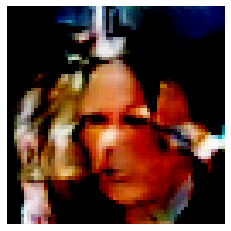

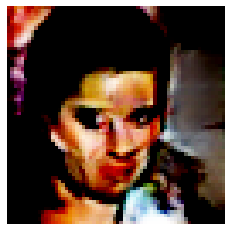

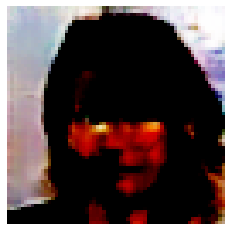

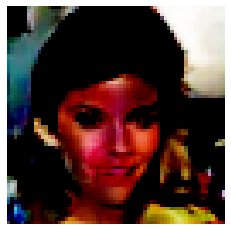

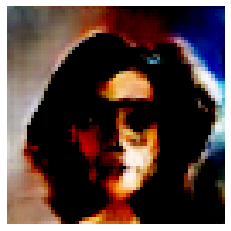

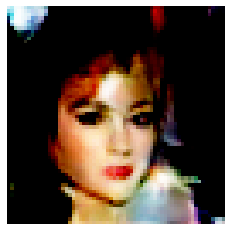

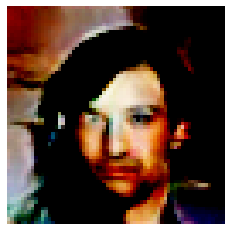

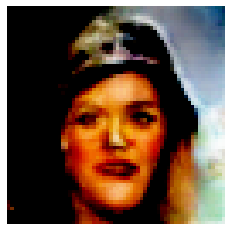

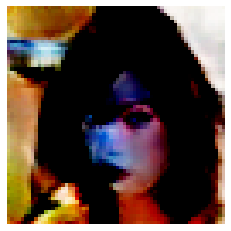

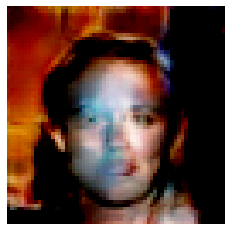

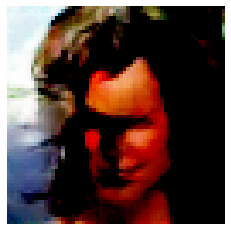

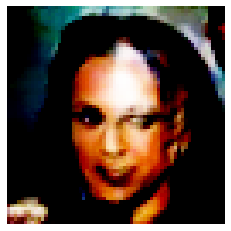

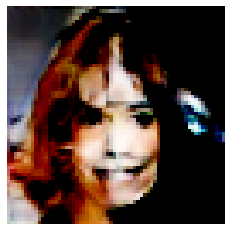

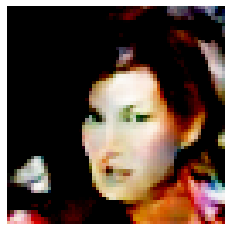

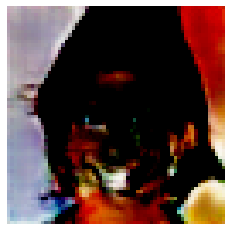

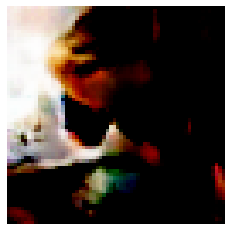

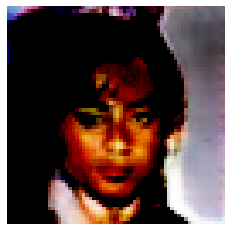

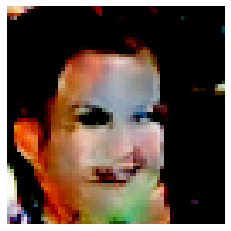

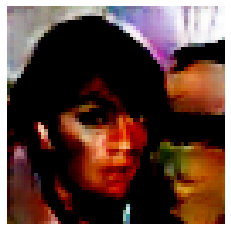

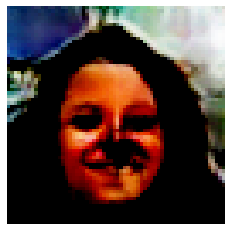

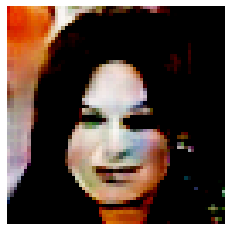

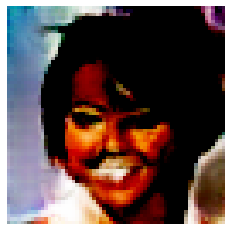

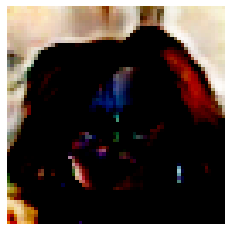

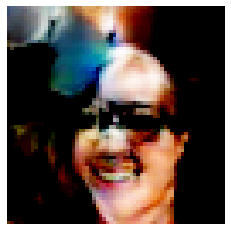

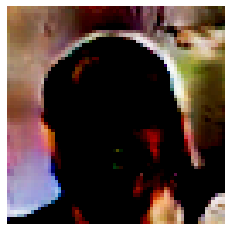

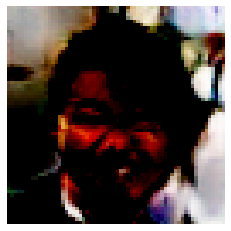

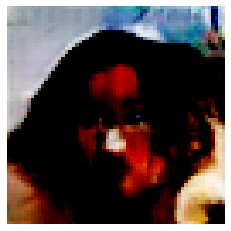

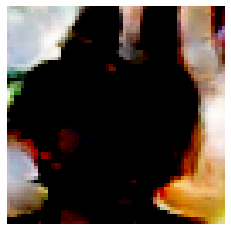

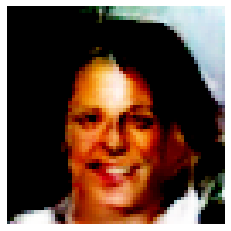

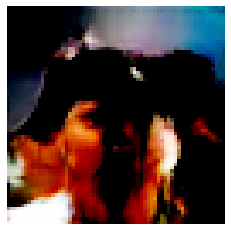

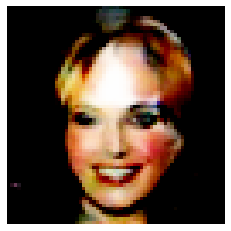

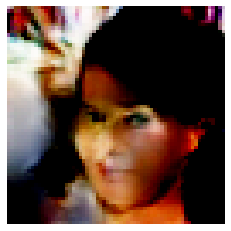

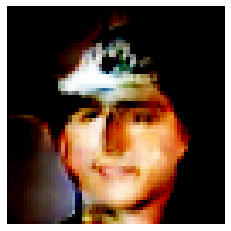

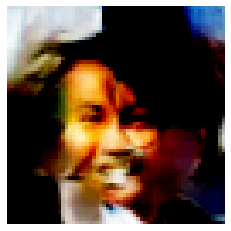

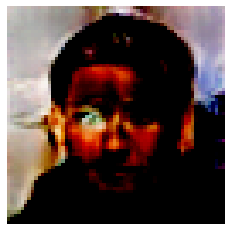

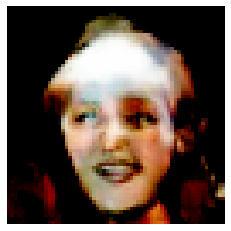

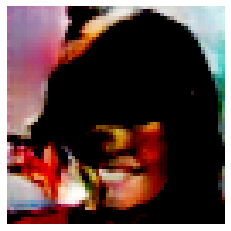

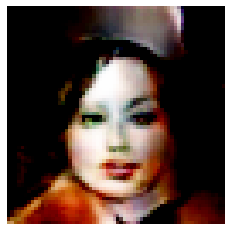

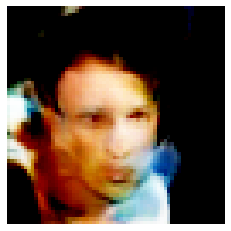

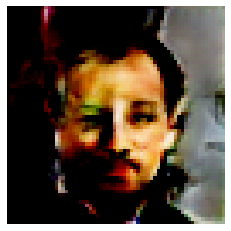

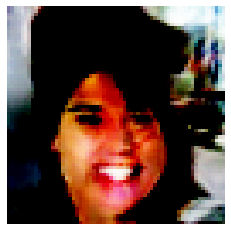

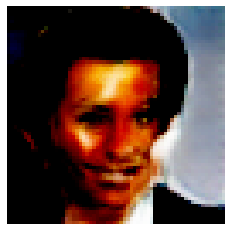

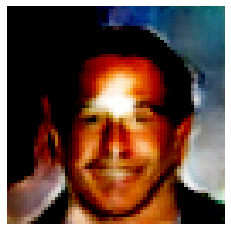

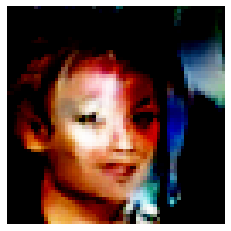

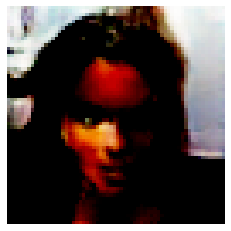

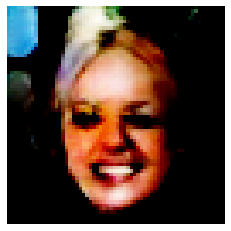

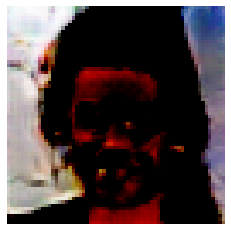

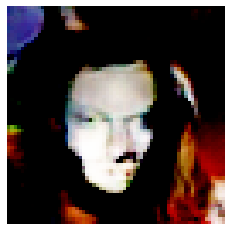

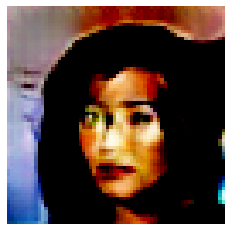

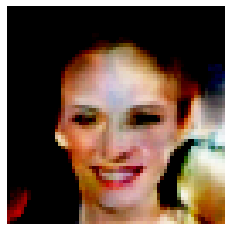

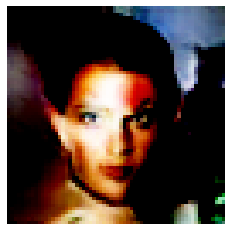

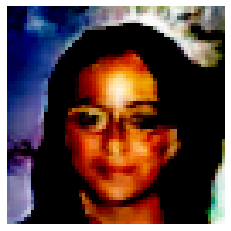

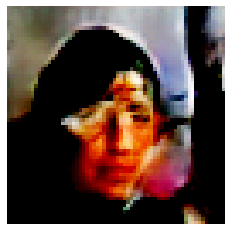

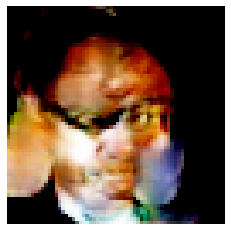

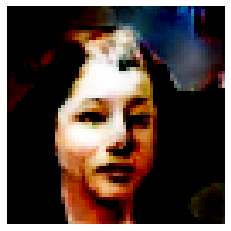

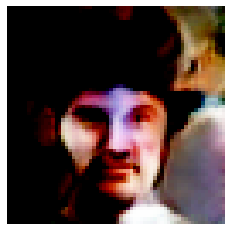

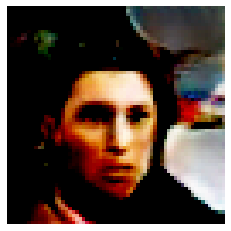

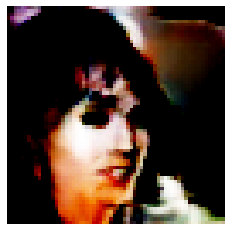

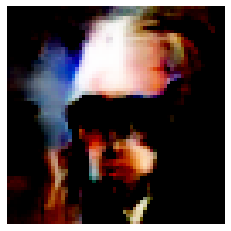

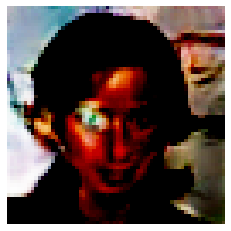

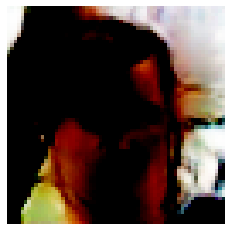

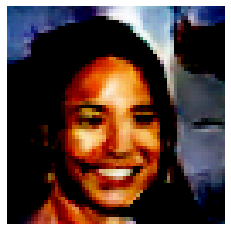

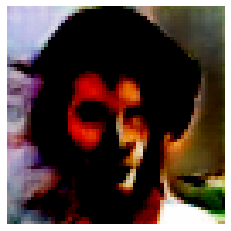

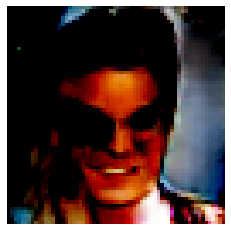

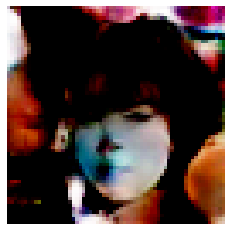

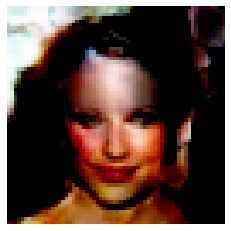

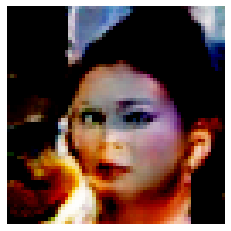

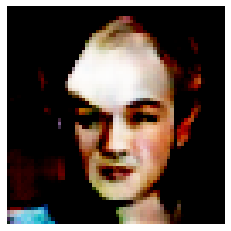

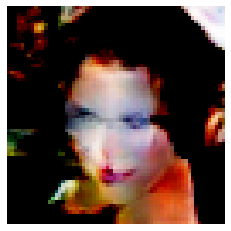

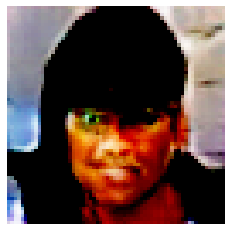

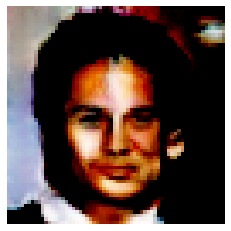

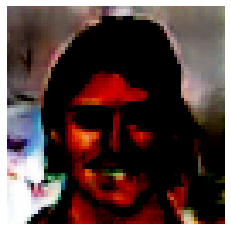

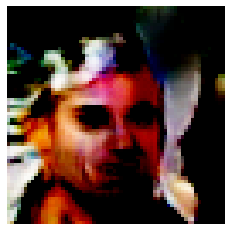

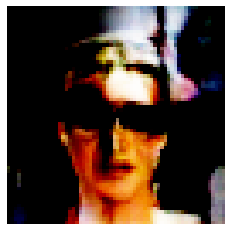

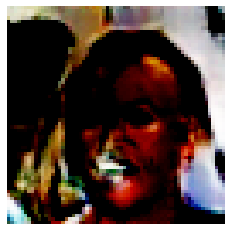

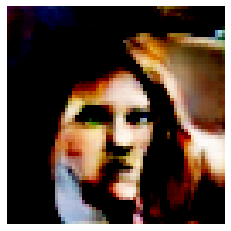

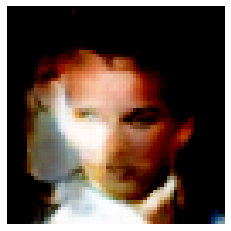

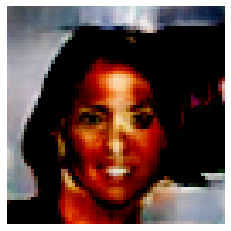

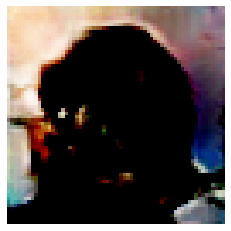

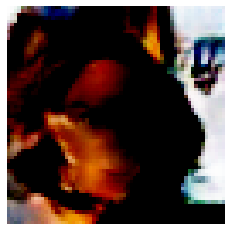

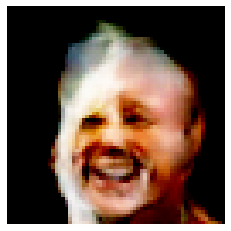

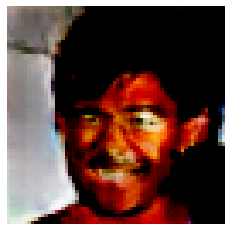

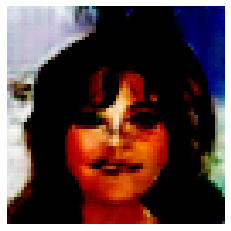

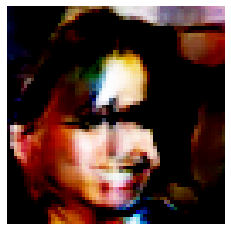

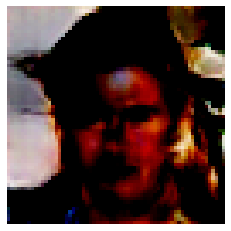

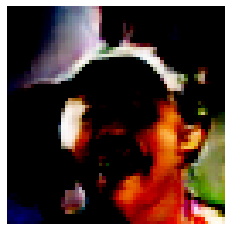

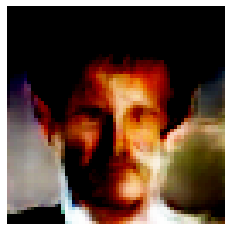

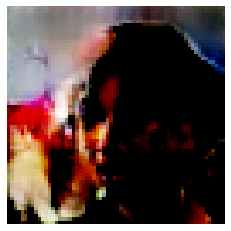

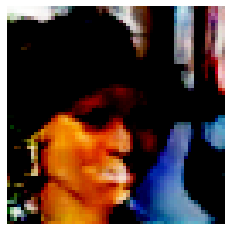

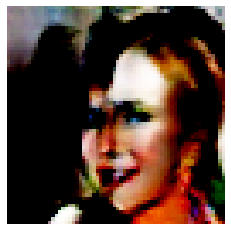

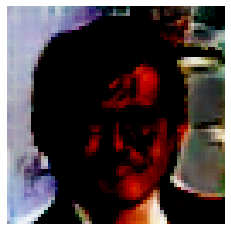

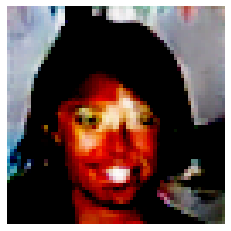

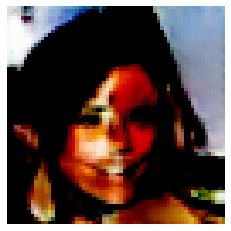

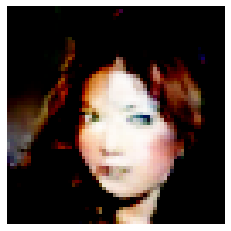

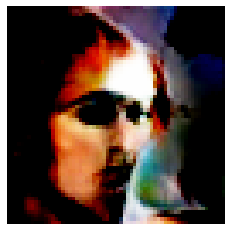

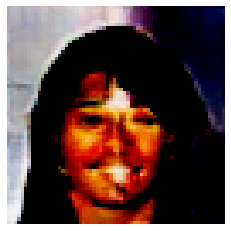

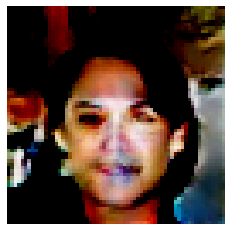

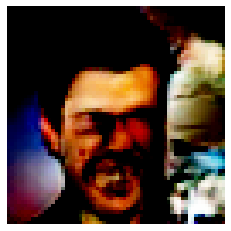

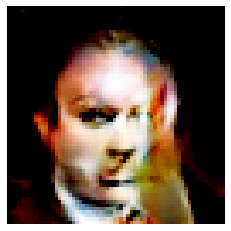

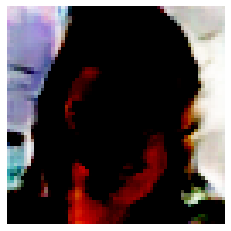

In [ ]:
for i in range(100):
    noise = torch.randn((1, latent_size, 1, 1)).to(device)
    imshow(G(noise).view(3, 64, 64).detach().cpu())

Подводя итог можно сказать, что не все лица получились похожими на настоящие, тем не менее есть несколько очень правдоподобных изображений. Здесь представлена основная идея работы и реализация GAN на свертках. Дополнительно можно проводить некоторые [оптимизации](https://github.com/soumith/ganhacks), которые применяются для улучшения стабильности и увелечения скорости сходимости ганов. Тем не менее в данной задаче они не добавляли явного преимущества. 